In [174]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
import tqdm
import geopandas as gpd
import geopy.geocoders as geocoders
import networkx as nx
from geopy.distance import geodesic
import folium
import shapely
import webbrowser

from shapely.geometry import Point
from shapely.ops import nearest_points
from shapely.geometry import LineString
from shapely.geometry import MultiLineString
from shapely.geometry import MultiPoint

In [175]:
distance_matrix_df = pd.read_csv('distance_matrix.csv', index_col=0)
distance_matrix_straigt_line_df = pd.read_csv('distance_matrix_straight_line.csv', index_col=0)
path_matrix_df = pd.read_pickle('path_matrix_df.pkl')

(2201466.728842696, 2251903.4973147013, 6440043.130753223, 6468528.844798662)

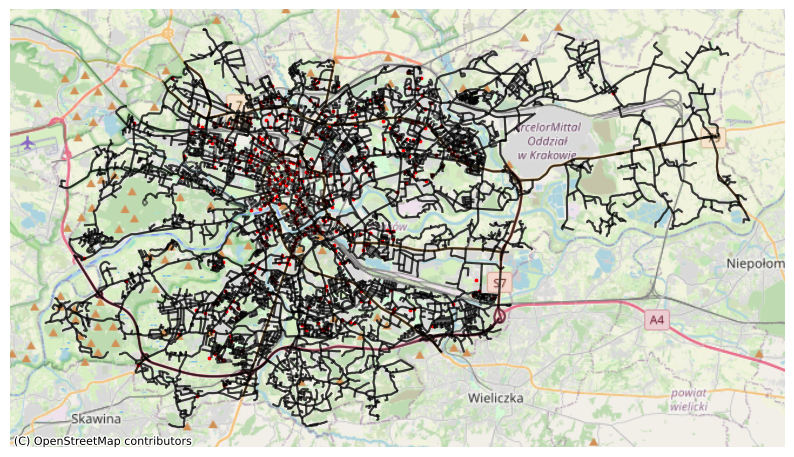

In [176]:
zabki_gdf = gpd.read_file('zabki_krakow.geojson')
zabki_gdf = zabki_gdf.to_crs(epsg=4326)
nearest_gdf = gpd.read_file('nearest.geojson')
nearest_gdf = nearest_gdf.to_crs(epsg=4326)

import osmnx as ox

G = ox.graph_from_place('Kraków, Poland', network_type='drive')
# Utworzenie GeoDataFrame z ulicami 
streets_gdf = ox.graph_to_gdfs(G, nodes=False, edges=True, node_geometry=False, fill_edge_geometry=True)


#plot map of Krakow
import contextily as ctx
fig, ax = plt.subplots(figsize=(10, 10))
streets_gdf.to_crs(epsg=3857).plot(ax=ax, color='black', alpha=0.5, markersize=2)
zabki_gdf.to_crs(epsg=3857).plot(ax=ax, color='red', alpha=1, markersize=3)
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)
plt.axis('off')

In [177]:
# graph creation
G = nx.Graph()

for idx, row in tqdm.tqdm(streets_gdf.iterrows(), total=streets_gdf.shape[0]):
    coords = list(row['geometry'].coords)
    for i in range(len(coords) - 1):
        u = coords[i]
        v = coords[i + 1]
        point1 = Point(u)
        point2 = Point(v)
        distance = geodesic((point1.y, point1.x), (point2.y, point2.x)).m
        G.add_edge(u, v, weight=distance)


100%|██████████| 21137/21137 [00:13<00:00, 1510.76it/s]


# Najbliższe żabki w linii prostej do adresu

Ta komórka pozwala znaleźć k najbliższych żabek w linii prostej do konkretnego adresu.

Adres wyszukiwany jest przez geolocator Nominatim bazujący na openstreetmap, jeśli nie udało się znaleźć adresu warto:
- odczekać chwilę i spróbować ponownie
- spróbować inny adres
- zmienić user_agent



Adres:  30, Aleja Adama Mickiewicza, Czarna Wieś, Krowodrza, Kraków, województwo małopolskie, 30-059, Polska
Latitude:  50.0659801
Longitude:  19.9178761


(2215999.733268638, 2218821.9940548213, 6457064.181648949, 6459170.341391637)

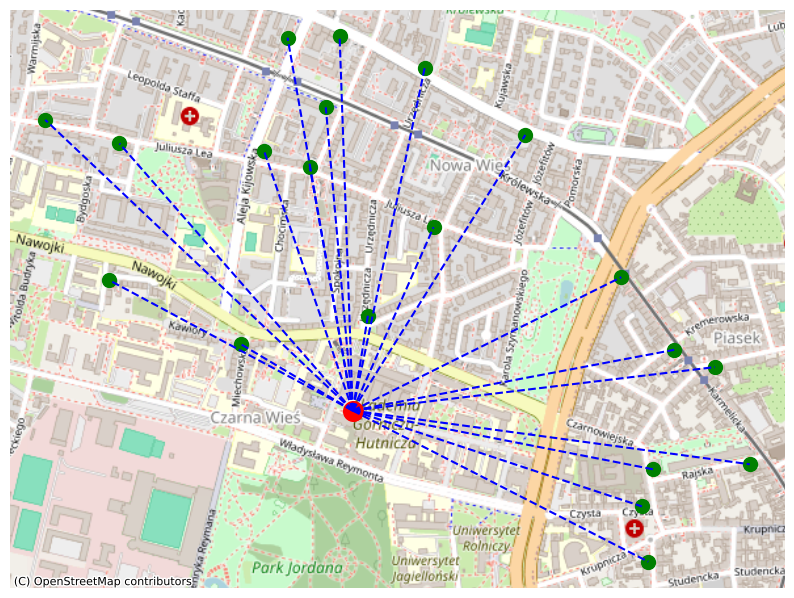

In [178]:
# Basic
adres = "Adama Mickiewicza 30, 30-059 Kraków" # przykładowy adres (AGH w Krakowie)
k = 20


geolocator = geocoders.Nominatim(user_agent="krakow_zabki")
lokalizacja = geolocator.geocode(adres)

lat, lon = 0, 0

if lokalizacja is None:
    print("Nie znaleziono lokalizacji")
    raise SystemExit

print("Adres: ", lokalizacja.address)
print("Latitude: ", lokalizacja.latitude)
print("Longitude: ", lokalizacja.longitude)
lat = lokalizacja.latitude
lon = lokalizacja.longitude

from shapely.geometry import Point
from shapely.ops import nearest_points

point = Point(lon, lat) 

closest_points = []
for i, row in zabki_gdf.iterrows():
    distance = geodesic((lat, lon), (row['geometry'].y, row['geometry'].x)).m
    closest_points.append((row['id'], distance))
closest_points = sorted(closest_points, key=lambda x: x[1])[:k]
closest_points

nearest_points_gdf = gpd.GeoDataFrame(columns=['id', 'geometry'])
for np in closest_points:
    nearest_points_gdf = pd.concat([nearest_points_gdf, zabki_gdf[zabki_gdf['id'] == np[0]]])
nearest_points_gdf

#plot map of Krakow
import contextily as ctx
fig, ax = plt.subplots(figsize=(10, 10))
nearest_points_gdf.to_crs(epsg=3857).plot(ax=ax, color='green', alpha=1, markersize=100)
#plot point
point_gdf = gpd.GeoDataFrame(geometry=[point])
point_gdf.crs = 'EPSG:4326'
point_gdf = point_gdf.to_crs(epsg=3857)
point_gdf.plot(ax=ax, color='red', markersize=200)

straight_lines_gdf = gpd.GeoDataFrame(columns=['geometry'])
for np in closest_points:
    straight_lines_gdf = pd.concat([straight_lines_gdf, gpd.GeoDataFrame(geometry=[LineString([point, zabki_gdf[zabki_gdf['id'] == np[0]]['geometry'].values[0]])])])
straight_lines_gdf.crs = 'EPSG:4326'
straight_lines_gdf = straight_lines_gdf.to_crs(epsg=3857)
straight_lines_gdf.plot(ax=ax, color='blue', linestyle='dashed')


ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)
plt.axis('off')

In [179]:
# interactive map 
m = folium.Map(location=[lat, lon], zoom_start=13)
folium.Marker([lat, lon], popup=str(lokalizacja.address)).add_to(m)
for np in closest_points:
    folium.Marker([zabki_gdf[zabki_gdf['id'] == np[0]]['geometry'].values[0].y, zabki_gdf[zabki_gdf['id'] == np[0]]['geometry'].values[0].x],
                   popup='Żabka <br> ID: ' + str(np[0]) + '<br> Distance: ' + str(round(np[1], 2)) + ' m').add_to(m)
for np in closest_points:
    folium.PolyLine([(lat, lon), (zabki_gdf[zabki_gdf['id'] == np[0]]['geometry'].values[0].y, zabki_gdf[zabki_gdf['id'] == np[0]]['geometry'].values[0].x)],
                    color='green', dash_array='5').add_to(m)
    
m.save('map.html')
webbrowser.open('map.html')

True

# Najbliższe żabki po ulicach do adresu

In [234]:
adres = "Rynek główny Kraków" # przykładowy adres
k = 25


geolocator = geocoders.Nominatim(user_agent="krakow_zabki")
lokalizacja = geolocator.geocode(adres)

lat, lon = 0, 0

if lokalizacja is None:
    print("Nie znaleziono lokalizacji")
    raise SystemExit

print("Adres: ", lokalizacja.address)
print("Latitude: ", lokalizacja.latitude)
print("Longitude: ", lokalizacja.longitude)
lat = lokalizacja.latitude
lon = lokalizacja.longitude

exact_adress_point = Point(lon, lat)


Adres:  Rynek Główny, Świętego Jana, Stare Miasto, Kraków, województwo małopolskie, 31-013, Polska
Latitude:  50.0615174
Longitude:  19.937106905856538


In [235]:
#find closest street_point to exact_adress_point
all_street_points = []
for idx, row in streets_gdf.iterrows():
    coords = list(row['geometry'].coords)
    for i in range(len(coords)):
        all_street_points.append(Point(coords[i]))

closest_street_point = nearest_points(exact_adress_point, MultiPoint(all_street_points))[1]
distance = geodesic((exact_adress_point.y, exact_adress_point.x), (closest_street_point.y, closest_street_point.x)).m
print("Closest street point: ", closest_street_point)
print("Distance: ", distance, "m")

#find shortest paths from closest_street_point to all nearest_points
shortest_paths = []
shortest_lengths = []
zabka_ids = []
for i in tqdm.tqdm(range(nearest_gdf.shape[0])):
    path = nx.shortest_path(G, tuple(closest_street_point.coords)[0], tuple(nearest_gdf['geometry'].iloc[i].coords)[0], weight='weight')
    zabka_ids.append(nearest_gdf['id'].iloc[i])
    length = 0
    for j in range(len(path) - 1):
        length += G[path[j]][path[j + 1]]['weight']
    length += 2*(nearest_gdf['distance'].iloc[i] + distance)
    shortest_paths.append(path)
    shortest_lengths.append(length)

shortest_paths_df = pd.DataFrame({'path': shortest_paths, 'length': shortest_lengths, 'zabka_id': zabka_ids})
shortest_paths_df = shortest_paths_df.sort_values(by='length')
shortest_paths_df = shortest_paths_df.reset_index(drop=True)


Closest street point:  POINT (19.9365806 50.0609405)
Distance:  74.4167753693789 m


100%|██████████| 369/369 [00:23<00:00, 15.72it/s]


(2218163.618860215, 2220958.903594195, 6455698.38400773, 6457633.694173466)

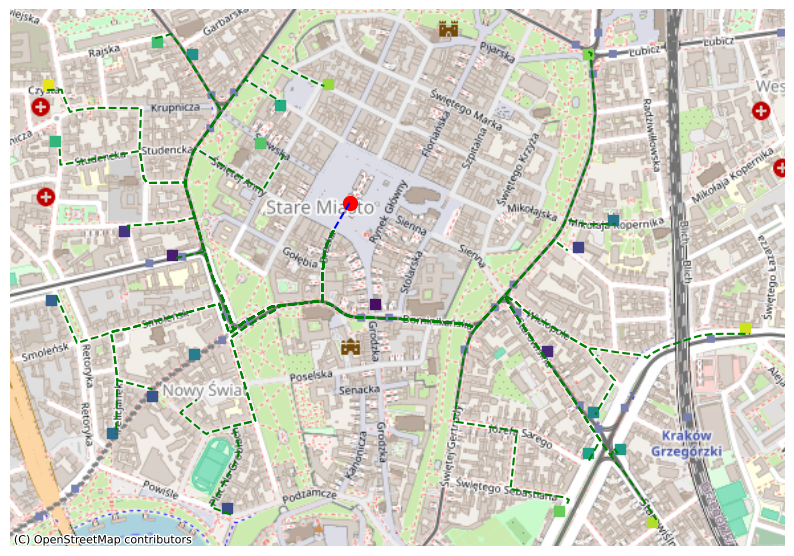

In [236]:
#basic wykres
shortest_paths_gdf = gpd.GeoDataFrame(columns=['geometry'])
k_gradient = sns.color_palette("viridis", k)

for i in range(k):
    path = shortest_paths_df['path'].iloc[i]
    line = LineString([Point(x) for x in path])
    shortest_paths_gdf = pd.concat([shortest_paths_gdf, gpd.GeoDataFrame(geometry=[line])])
shortest_paths_gdf.crs = 'EPSG:4326'
shortest_paths_gdf = shortest_paths_gdf.to_crs(epsg=3857)

#plot map of Krakow
import contextily as ctx
fig, ax = plt.subplots(figsize=(10, 10))
shortest_paths_gdf.plot(ax=ax, color='green', linestyle='dashed')

point_gdf = gpd.GeoDataFrame(geometry=[exact_adress_point])
point_gdf.crs = 'EPSG:4326'
point_gdf = point_gdf.to_crs(epsg=3857)
point_gdf.plot(ax=ax, color='red', markersize=100)

#plot line between exact_adress_point and closest_street_point
line = LineString([exact_adress_point, closest_street_point])
line_gdf = gpd.GeoDataFrame(geometry=[line])
line_gdf.crs = 'EPSG:4326'
line_gdf = line_gdf.to_crs(epsg=3857)
line_gdf.plot(ax=ax, color='blue', linestyle='dashed')

for i in range(k):
    zabka_id = shortest_paths_df['zabka_id'].iloc[i]
    zabka = zabki_gdf[zabki_gdf['id'] == zabka_id]
    zabka = zabka.to_crs(epsg=3857)
    zabka.plot(ax=ax, color=k_gradient[i], markersize=50, marker='s')

ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)
plt.axis('off')

In [237]:
#interactive map
m = folium.Map(location=[lat, lon], zoom_start=13)
folium.Marker([lat, lon], popup=str(lokalizacja.address)).add_to(m)
for i in range(k):
    zabka_id = shortest_paths_df['zabka_id'].iloc[i]
    zabka = zabki_gdf[zabki_gdf['id'] == zabka_id]
    folium.Marker([zabka['geometry'].values[0].y, zabka['geometry'].values[0].x],
                    popup='Żabka <br> ID: ' + str(zabka_id) + '<br> Distance: ' + str(round(shortest_paths_df['length'].iloc[i], 2)) + ' m').add_to(m)
for i in range(k):
    path = shortest_paths_df['path'].iloc[i]
    folium.PolyLine([(x[1], x[0]) for x in path],
                    color='green', dash_array='5').add_to(m)

folium.PolyLine([(closest_street_point.y, closest_street_point.x), (lat, lon)],
                    color='blue').add_to(m)

#lines between nearest_gdf points and exact zabka points
for i in range(k):
    zabka_id = shortest_paths_df['zabka_id'].iloc[i]
    zabka = zabki_gdf[zabki_gdf['id'] == zabka_id]
    nearest = nearest_gdf[nearest_gdf['id'] == zabka_id]
    folium.PolyLine([(zabka['geometry'].values[0].y, zabka['geometry'].values[0].x), (nearest['geometry'].values[0].y, nearest['geometry'].values[0].x)],
                    color='black').add_to(m)

m.save('map.html')
webbrowser.open('map.html')

True